<a href="https://colab.research.google.com/github/reedmarkham/meter-made/blob/main/meter_made.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

To-do:
*   Persist model and data to GCS bucket(s)
*   Fix evaluation of heuristic method

# Set variables and import libraries

In [1]:
DC_COORDS = [38.90720, -77.03690]

In [2]:
import datetime
import itertools
import os

from google.colab import drive
import dask.dataframe as dd
import pandas as pd
import numpy as np
import pyproj
from shapely.geometry import Point
from shapely.ops import transform
import geopandas as gpd
import folium
import branca.colormap as cm
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import lightgbm as lgb

In [3]:
!pip install pandarallel
from pandarallel import pandarallel
pandarallel.initialize()

INFO: Pandarallel will run on 1 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


# Load the DC parking data previously downloaded to Google Drive

In [4]:
drive.mount('/content/drive', force_remount=True)
!ls '/content/drive/MyDrive/dc-parking-data'

Mounted at /content/drive
Accessible_Parking_Zones.geojson
Address_Points.geojson
Parking_Blockface.geojson
Parking_Violations_Issued_in_April_2024.geojson
Parking_Violations_Issued_in_August_2024.geojson
Parking_Violations_Issued_in_December_2024.geojson
Parking_Violations_Issued_in_February_2024.geojson
Parking_Violations_Issued_in_January_2024.geojson
Parking_Violations_Issued_in_July_2024.geojson
Parking_Violations_Issued_in_June_2024.geojson
Parking_Violations_Issued_in_March_2024.geojson
Parking_Violations_Issued_in_May_2024.geojson
Parking_Violations_Issued_in_November_2024.geojson
Parking_Violations_Issued_in_October_2024.geojson
Parking_Violations_Issued_in_September_2024.geojson
Parking_Zones.geojson
Residential_and_Visitor_Parking_Zones.geojson
Roadway_Blockface.geojson
Street_Right_Of_Way.geojson
Valet_Parking.geojson


# Check out the DC street sweeping routes

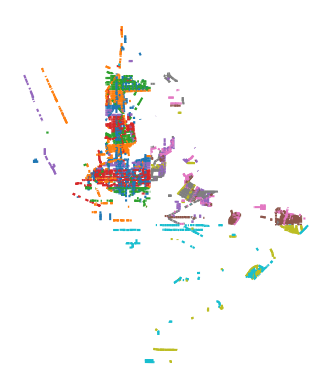

In [5]:
zones = gpd.read_file('/content/drive/MyDrive/dc-parking-data/Parking_Zones.geojson')
ax = zones[zones.PARKINGGROUP == 'Sweeping'].plot(column='ROUTEID')
ax.set_axis_off()
del ax

# Ingest addresses and routes

In [6]:
addresses = gpd.read_file('/content/drive/MyDrive/dc-parking-data/Address_Points.geojson')
a_cols = ['ADDRESS', 'ZIPCODE', 'BLOCKKEY', 'ROUTEID', 'LATITUDE', 'LONGITUDE']
addresses = addresses[a_cols]

# & (gdf.ROUTEID == '11072862')
routes = zones[(zones.PARKINGGROUP == 'Sweeping') & (zones.PARKINGDAYGROUP == 'Monday') & (zones.PARKINGHOURGROUP == 'AM')].set_crs('EPSG:4326')
del zones

routes = routes.sort_values(by='MEAS_FROM')
r_cols = ['ROUTEID', 'ZONEID', 'SIGNS', 'SIGNTEXT', 'SIGNCODE', 'MEAS_FROM', 'MEAS_TO', 'STARTTIME', 'ENDTIME', 'BLOCKFACEKEY', 'geometry']
routes = routes[r_cols]
routes_df = routes.merge(addresses, on='ROUTEID', how='inner')
del routes

routes_gdf = gpd.GeoDataFrame(
    routes_df,
    geometry=gpd.points_from_xy(routes_df.LONGITUDE, routes_df.LATITUDE),
    crs='EPSG:4326'
)
del routes_df

#display(routes_gdf.sort_values(by='ADDRESS'))

# Ingest tickets

In [7]:
t_jan = gpd.read_file('/content/drive/MyDrive/dc-parking-data/Parking_Violations_Issued_in_January_2024.geojson')
t_feb = gpd.read_file('/content/drive/MyDrive/dc-parking-data/Parking_Violations_Issued_in_February_2024.geojson')
t_mar = gpd.read_file('/content/drive/MyDrive/dc-parking-data/Parking_Violations_Issued_in_March_2024.geojson')
t_apr = gpd.read_file('/content/drive/MyDrive/dc-parking-data/Parking_Violations_Issued_in_April_2024.geojson')
t_may = gpd.read_file('/content/drive/MyDrive/dc-parking-data/Parking_Violations_Issued_in_May_2024.geojson')
t_jun = gpd.read_file('/content/drive/MyDrive/dc-parking-data/Parking_Violations_Issued_in_June_2024.geojson')
t_jul = gpd.read_file('/content/drive/MyDrive/dc-parking-data/Parking_Violations_Issued_in_July_2024.geojson')
t_aug = gpd.read_file('/content/drive/MyDrive/dc-parking-data/Parking_Violations_Issued_in_August_2024.geojson')
t_sep = gpd.read_file('/content/drive/MyDrive/dc-parking-data/Parking_Violations_Issued_in_September_2024.geojson')
t_oct = gpd.read_file('/content/drive/MyDrive/dc-parking-data/Parking_Violations_Issued_in_October_2024.geojson')
t_nov = gpd.read_file('/content/drive/MyDrive/dc-parking-data/Parking_Violations_Issued_in_November_2024.geojson')
t_dec = gpd.read_file('/content/drive/MyDrive/dc-parking-data/Parking_Violations_Issued_in_December_2024.geojson')
t = pd.concat([t_jan, t_feb, t_mar, t_apr, t_may, t_jun, t_jul, t_aug, t_sep, t_oct, t_nov, t_dec])

for t_ in [t_jan, t_feb, t_mar, t_apr, t_may, t_jun, t_jul, t_aug, t_sep, t_oct, t_nov, t_dec]:
  del t_

tickets = gpd.GeoDataFrame(
    t,
    geometry=gpd.points_from_xy(t.LONGITUDE, t.LATITUDE),
    crs="EPSG:4326"
)
del t

# Fill NaN values in VIOLATION_PROC_DESC with an empty string before using .str.contains()
tickets['VIOLATION_PROC_DESC'] = tickets['VIOLATION_PROC_DESC'].fillna('')
#display(tickets[tickets.VIOLATION_PROC_DESC.str.contains('EXPIRED METER')])

# Join street cleaning parking tickets with sweeping routes

In [8]:
routes_gdf.geometry = routes_gdf.geometry.set_precision(grid_size=0.0001).force_2d()
cleaning_tix = tickets[tickets.VIOLATION_CODE == 'P173']
cleaning_tix.geometry = cleaning_tix.geometry.set_precision(grid_size=0.0001).force_2d()
tickets_and_routes = gpd.sjoin(routes_gdf, cleaning_tix, how='inner', predicate='intersects')

del routes_gdf
del cleaning_tix

tickets_and_routes = tickets_and_routes[['TICKET_NUMBER', 'ROUTEID', 'ISSUE_DATE', 'ISSUE_TIME', 'geometry']]
tickets_and_routes = tickets_and_routes.sort_values(by='TICKET_NUMBER').drop_duplicates()
tickets_and_routes.geometry = tickets_and_routes.geometry.set_precision(grid_size=0.00001)

In [9]:
tickets_and_routes['timestamp'] = tickets_and_routes.apply(
    lambda row: str(row['ISSUE_DATE'].date()) + ' ' + row['ISSUE_TIME'],
    axis=1
    )
tickets_and_routes['timestamp'] = pd.to_datetime(
    tickets_and_routes['timestamp'],
    format='%Y-%m-%d %H%M',
    errors='coerce'
    )
tickets_and_routes = tickets_and_routes[['geometry', 'ROUTEID', 'timestamp']]
display(tickets_and_routes)

,geometry,ROUTEID,timestamp
79027,POINT (-77.011 38.919),11090152,2024-04-09 12:56:00
83229,POINT (-77.011 38.919),11090152,2024-04-09 12:59:00
86017,POINT (-77.011 38.919),11090152,2024-04-09 13:00:00
124964,POINT (-77.04 38.918),11088462,2024-04-15 10:07:00
146212,POINT (-77.04 38.918),11088462,2024-04-15 10:16:00
...,...,...,...
22590,POINT (-77.04 38.923),11033862,2024-10-28 11:09:00
300426,POINT (-77.03 38.928),11001302,2024-10-28 09:55:00
15749,POINT (-77.031 38.912),11025932,2024-10-24 10:50:00
190875,POINT (-77.033 38.907),11063182,2024-10-29 09:39:00


# Visualize frequency and order (by ticket timestamp) of street cleaning parking tickets along sweeping routes

In [10]:
tickets_and_routes_filtered = tickets_and_routes[
    tickets_and_routes['timestamp'].dt.date == pd.to_datetime('2024-10-28').date()
]

del tickets_and_routes

map = folium.Map(location=DC_COORDS, zoom_start=12, tiles="cartodb positron")

#TO-DO: compute elapsed_minutes within ROUTEID as well as colormap but then plot for each ROUTEID layer the respective colormap and elapsed_minutes in popup ("since street cleaning route started")

tickets_and_routes_filtered['elapsed_minutes'] = (tickets_and_routes_filtered['timestamp'] - tickets_and_routes_filtered['timestamp'].min()).dt.total_seconds() / 60

colormap = cm.linear.Blues_03.scale(
    tickets_and_routes_filtered.elapsed_minutes.min(),
    tickets_and_routes_filtered.elapsed_minutes.max()
    )

geometry_counts = tickets_and_routes_filtered.groupby(['geometry', 'ROUTEID'])['timestamp'].count().reset_index()
earliest_timestamps = tickets_and_routes_filtered.groupby(['geometry', 'ROUTEID'])['timestamp'].min().rename('earliest_timestamp').reset_index()

route_layers = {}
for route_id in tickets_and_routes_filtered['ROUTEID'].unique():
  route_data = tickets_and_routes_filtered[tickets_and_routes_filtered['ROUTEID'] == route_id]
  route_fg = folium.FeatureGroup(name=f"Route {route_id}")

  for idx, row in route_data.sort_values(by='elapsed_minutes').iterrows():
      lon = row.geometry.x
      lat = row.geometry.y
      count_for_geometry = int(geometry_counts[geometry_counts.geometry == row.geometry]['timestamp'].iloc[0] if geometry_counts[geometry_counts.geometry == row.geometry]['timestamp'].size > 0 else 0)
      earliest_timestamp = earliest_timestamps[(earliest_timestamps.geometry == row.geometry) & (earliest_timestamps.ROUTEID == route_id)]['earliest_timestamp'].iloc[0] if earliest_timestamps[(earliest_timestamps.geometry == row.geometry) & (earliest_timestamps.ROUTEID == route_id)]['earliest_timestamp'].size > 0 else None

      popup_html = f"""
      <h1> Street sweeping summary:</h1>
      <p># of tickets: {count_for_geometry}</p>
      <p>Started at: {earliest_timestamp}</p>
      """

      folium.CircleMarker(
          location=[lat, lon],
          radius=count_for_geometry,
          color='none',
          fill=True,
          fill_color=colormap(row.elapsed_minutes),
          fill_opacity=0.7,
          popup=popup_html
      ).add_to(route_fg)

  route_layers[route_id] = route_fg
  route_fg.add_to(map)

del route_layers
del tickets_and_routes_filtered
del geometry_counts
del earliest_timestamps

colormap.add_to(map)
folium.LayerControl().add_to(map)

map

# Compute clusters of expired parking meter ticket locations (x, y coords) using DBSCAN

In [11]:
tix = tickets[tickets.VIOLATION_CODE == 'P039']
del tickets

array_data = []
for index, row in tix.iterrows():
  if row.geometry and row.geometry.is_valid and not row.geometry.is_empty:
    x_coord = row.geometry.x
    y_coord = row.geometry.y
    date = row['ISSUE_DATE'].date()

    try:
        time_of_day = datetime.time(int(row['ISSUE_TIME'].zfill(4)[:2]), int(row['ISSUE_TIME'].zfill(4)[2:]))
    except (ValueError, TypeError):
        print(f"Invalid time format: {row['ISSUE_TIME']}, skipping row")
        continue

    week_day =  row['ISSUE_DATE'].date().isoweekday()
    array_data.append([x_coord, y_coord, date, week_day, time_of_day])

X_full = np.array(array_data)
del array_data

X_full_df = pd.DataFrame(X_full, columns=['x', 'y', 'd', 'w', 't'])
X_full_df['h'] = X_full_df['t'].apply(lambda t: (t.hour + (t.minute + 30) // 60) % 24)
X_full = X_full_df.values

In [12]:
to_cluster = pd.DataFrame(X_full, columns=['x', 'y', 'd', 'w', 't', 'h'])
del X_full

In [13]:
def compute_dbscan_clusters(to_cluster, d, h):
  """Computes DBSCAN clusters for a given date and hour.

  Args:
    to_cluster: A pandas DataFrame with columns 'x', 'y', 'd', 'w', 't', 'h'.
    d: The date to filter for.
    h: The hour to filter for.

  Returns:
    A pandas DataFrame with columns 'x', 'y', 'cluster', containing the clustered
    data for the specified date and hour.
  """
  filtered_data = to_cluster[(to_cluster['d'] == d) & (to_cluster['h'] == h)][['x', 'y']]
  if filtered_data.empty:
    return pd.DataFrame(columns=['x', 'y', 'cluster'])
  db = DBSCAN(eps=0.01, min_samples=5).fit(filtered_data)
  labels = db.labels_
  core = db.core_sample_indices_
  clustered_data = filtered_data.copy()
  clustered_data['cluster'] = labels
  return clustered_data

compute_dbscan_clusters(to_cluster, datetime.date(2024, 6, 25), 11)

,x,y,cluster
19697,-77.04,38.897,0
19698,-77.04,38.897,0
20952,-77.042,38.898,0
21161,-77.02,38.887,-1
21270,-77.05,38.903,0
21417,-77.038,38.907,0
21418,-77.038,38.907,0
21419,-77.037,38.907,-1
21497,-77.008,38.899,1
21498,-77.008,38.899,1


In [14]:
map = folium.Map(location=DC_COORDS, zoom_start=12, tiles="cartodb positron")

date_to_plot = datetime.date(2024, 6, 25)
hour_to_plot = 11

clustered_data = compute_dbscan_clusters(to_cluster, date_to_plot, hour_to_plot)
colors = ['red', 'blue', 'green', 'purple', 'orange', 'darkred', 'lightred', 'beige']

if not clustered_data.empty:
  for (cluster_id, color_) in zip(clustered_data['cluster'].unique(), colors):
    if cluster_id == -1:  # Noise points
      continue

    cluster_points = clustered_data[clustered_data['cluster'] == cluster_id]
    if not cluster_points.empty:
      for _, cp in cluster_points.iterrows():
        folium.CircleMarker(
            location=[cp['y'], cp['x']],
            radius=3,
            color=color_,
            fill=True,
            fill_color=color_,
            fill_opacity=0.7,
            popup=f"Cluster {cluster_id}"
        ).add_to(map)

map

In [15]:
combinations = list(itertools.product(X_full_df['d'].unique(), X_full_df['h'].unique()))

cluster_labels_list = []
for d, h in combinations:
  cluster_labels = compute_dbscan_clusters(X_full_df, d, h)
  if not cluster_labels.empty:
    cluster_labels['d'] = d
    cluster_labels['w'] = d.isoweekday()
    cluster_labels['h'] = h
    cluster_labels_list.append(cluster_labels)

cluster_labels_df = pd.concat(cluster_labels_list, ignore_index=True)
del cluster_labels_list

# Predict parking tickets from day, time, and cluster locations using heuristics

In [16]:
filtered_df = cluster_labels_df[(cluster_labels_df['d'] == pd.to_datetime('2024-06-25').date()) & (cluster_labels_df['h'] == 11)]

test_clusters_gdf = gpd.GeoDataFrame(
    filtered_df,
    geometry=gpd.points_from_xy(filtered_df.x, filtered_df.y),
    crs='EPSG:4326'
)
test_clusters_gdf = test_clusters_gdf.to_crs('EPSG:32618')

In [17]:
addresses_gdf = gpd.GeoDataFrame(
    addresses,
    geometry=gpd.points_from_xy(addresses.LONGITUDE, addresses.LATITUDE),
    crs='EPSG:4326'
)

addresses_gdf = addresses_gdf.to_crs('EPSG:32618')

In [18]:
a_gdf = addresses_gdf[['ADDRESS', 'geometry']]
del addresses_gdf

a_gdf['min_dist'] = a_gdf.parallel_apply(lambda row: row.geometry.distance(test_clusters_gdf.geometry).min()/1609.34, axis=1)

<Axes: >

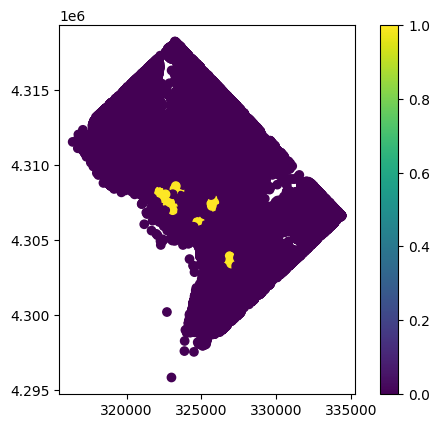

In [19]:
def estimate_ticket(dist):
  return 1 if dist < 0.25 else 0

a_gdf['ticketed'] = a_gdf['min_dist'].parallel_apply(estimate_ticket)
a_gdf.plot(column='ticketed', legend=True)

In [20]:
pct_ticketed = (tix[tix.VIOLATION_CODE == 'P039'].sjoin(a_gdf, how='inner', predicate='intersects').shape[0] / tix.shape[0]) * 100
print(f"The heuristic estimated {pct_ticketed}% of tickets")
del a_gdf

The heuristic estimated 0.0% of tickets


# Predict parking tickets from cluster locations using LightGBM

In [21]:
final_df = cluster_labels_df[cluster_labels_df.cluster != -1]
final_df = final_df.groupby(['d', 'w', 'h', 'cluster'])[['x', 'y']].agg(lambda x: list(zip(x.values)))
final_df = final_df.applymap(lambda x: np.mean(np.array(x), axis=0) if x else np.array([])).reset_index()
final_df = final_df[['d', 'w', 'h', 'x', 'y', 'cluster']]
final_df.x = final_df.x.astype('float')
final_df.y = final_df.y.astype('float')

In [22]:
a = addresses[['LONGITUDE', 'LATITUDE']]
a['cluster'] = -1
a['x'] = a['LONGITUDE']
a['y'] = a['LATITUDE']
a = a[['x', 'y', 'cluster']]

In [ ]:
!rm -rf /tmp/batch*.parquet
!rm -rf /propagation_data/*.parquet

def cross_join_dask(df1, df2):
    ddf1 = dd.from_pandas(df1)
    ddf1.repartition(partition_size='100MB')
    ddf1.to_parquet('/tmp', write_index=False, name_function=lambda i: 'batch1.parquet')


    ddf2 = dd.from_pandas(df2)
    ddf2.repartition(partition_size='100MB')
    ddf2.to_parquet('/tmp', write_index=False, name_function=lambda i: 'batch2.parquet')

    ddf1 = dd.read_parquet('/tmp/batch1.parquet')
    ddf2 = dd.read_parquet('/tmp/batch2.parquet')
    ddf1['_temp_key'] = 1
    ddf2['_temp_key'] = 1
    result = dd.merge(ddf1, ddf2, on='_temp_key').drop('_temp_key', axis=1).compute()

    del ddf1
    del ddf2

    return result

os.makedirs('/propagation_data', exist_ok=True)
dh = final_df[['d', 'h']].drop_duplicates()
batch_size = 10000
for i in range(0, len(a), batch_size):
  batch = a[i:i + batch_size]
  cross_joined_df = cross_join_dask(batch, dh)
  cross_joined_df.to_parquet(f'/propagation_data/batch_{i}.parquet')
  del cross_joined_df
  print(f"Processed batch {i} out of {len(a)} input rows")

del a
del dh
!rm -rf /tmp/batch*.parquet

Processed batch 0 out of 144401 input rows
Processed batch 10000 out of 144401 input rows
Processed batch 20000 out of 144401 input rows
Processed batch 30000 out of 144401 input rows
Processed batch 40000 out of 144401 input rows
Processed batch 50000 out of 144401 input rows
Processed batch 60000 out of 144401 input rows
Processed batch 70000 out of 144401 input rows


In [ ]:
propagated_df = pd.DataFrame()
prop_data = [f'/propagation_data/{file}' for file in os.listdir('/propagation_data') if file.endswith('.parquet')]
for d in prop_data:
  print(f'Reading {d}')
  f = pd.read_parquet(d)
  pd.concat([propagated_df, f])
  del f
  print(f'Ingested {d}')

display(propagated_df)
!rm -rf /propagation_data/*.parquet

In [ ]:
final_df = pd.concat([cluster_labels_df[['d', 'w', 'h', 'x', 'y', 'cluster']], propagated_df])

del cluster_labels_df
del propagated_df
display(final_df)

In [ ]:
X = final_df[['d','w', 'h', 'x', 'y']]
final_df['y_hat'] = final_df['cluster'].apply(lambda x: 0 if x == -1 else 1)
y = final_df['y_hat']
display(final_df)

X['d'] = pd.to_numeric(X['d'].apply(lambda x: x.toordinal()))
X['w'] = pd.to_numeric(X['w'])
X['h'] = pd.to_numeric(X['h'])
X['x'] = pd.to_numeric(X['x'])
X['y'] = pd.to_numeric(X['y'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = lgb.LGBMClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

In [ ]:
predicted_df = pd.DataFrame(
    {'x': X_test['x'],
    'y': X_test['y'],
    'get_ticket': y_pred}
    )

predicted_gdf = gpd.GeoDataFrame(
    predicted_df,
    geometry=gpd.points_from_xy(predicted_df.x, predicted_df.y),
    crs='EPSG:4326'
)
del predicted_df

predicted_gdf.plot(column='get_ticket', legend=True)

In [ ]:
DT = '2024-06-25'
HR = 11
X = -77.03690
Y = 38.90720

sample_input = pd.DataFrame({
    'd': [pd.to_datetime(DT).toordinal()],
    'w': [pd.to_datetime(DT).date().isoweekday()]
    'h': [HR],
    'x': [X],
    'y': [Y]
})

prediction = model.predict(sample_input)

print(f"Will you get a parking ticket? {prediction}")